In [1]:
import csv
import dataset
import matplotlib.pyplot as plt
import midi
import numpy as np
import pathlib
import similarity
import tqdm.notebook as tqdm
from typing import List, Tuple

In [2]:
DATASET_ROOT = "../dataset/newbie-dataset"

FRAME_PER_SECOND = 20  # Hz
SLICE_DURATION = 5  # sec
EXPANSION_RATE = 1.5
SETTLING_FRAME = 5
COMPENSATION_FRAME = 0
SUBSEQUENCE_DTW = True

NUM_SAMPLES = 50
QUEUE_SIZE = 8

SAVE_ROOT = pathlib.Path("./save")
if not SAVE_ROOT.exists():
    SAVE_ROOT.mkdir(exist_ok=True, parents=True)

In [3]:
generator = dataset.new_generator(root=DATASET_ROOT,
                                  frame_per_second=FRAME_PER_SECOND,
                                  slice_duration=SLICE_DURATION,
                                  expansion_rate=EXPANSION_RATE,
                                  note_scale=1.00,
                                  mark_onset=True,
                                  shuffle=True)

In [4]:
# pos/neg-similarities: [histogram_distance, timewarping_distance, length_ratio]
pos_similarities: List[Tuple[float, float, float]] = []
neg_similarities: List[Tuple[float, float, float]] = []

In [5]:
prev_perfs: List[np.ndarray] = [None] * QUEUE_SIZE

In [6]:
decay_fn = midi.get_decay_fn("linear", settling_frame=SETTLING_FRAME)

In [10]:
with open(SAVE_ROOT / "pos.csv", "w", encoding="utf-8") as f1, \
     open(SAVE_ROOT / "neg.csv", "w", encoding="utf-8") as f2:
    pos_csvfile = csv.writer(f1, delimiter=",", quotechar="|")
    pos_csvfile.writerow(["Histogram distance", "Timewarping distance", "Length ratio"])

    neg_csvfile = csv.writer(f2, delimiter=",", quotechar="|")
    neg_csvfile.writerow(["Histogram distance", "Timewarping distance", "Length ratio"])

    count = 0
    
    execution_times = {
        "midi_matrix": 0.0,
        "timewarping": 0.0,
        "euclidean": 0.0,
        "total": 0.0,
    }

    try:
        for idx in tqdm.trange(NUM_SAMPLES, desc="Measuring similarities..."):
            score, perf, _ = next(generator)
            score_len = score.shape[-1]
            perf_len = perf.shape[-1]
            pos_histogram_distance, pos_timewarping_distance, pos_execution_times = similarity.measure(score, perf,
                                                                                                       compensation_frame=COMPENSATION_FRAME,
                                                                                                       decay_fn=decay_fn, subsequence=SUBSEQUENCE_DTW,
                                                                                                       measure_time=True)
            pos_length_ratio = perf_len / score_len
            pos_csvfile.writerow([pos_histogram_distance, pos_timewarping_distance, pos_length_ratio])
            pos_similarities.append((pos_histogram_distance, pos_timewarping_distance, pos_length_ratio))

            for k, v in pos_execution_times.items():
                execution_times[k] += v
                count += 1

            if isinstance(prev_perfs[0], np.ndarray):
                prev_perf = prev_perfs[0]
                prev_perf_len = prev_perf.shape[-1]
                neg_histogram_distance, neg_timewarping_distance = similarity.measure(score, prev_perf,
                                                                                      compensation_frame=COMPENSATION_FRAME,
                                                                                      decay_fn=decay_fn, subsequence=SUBSEQUENCE_DTW)
                neg_length_ratio = prev_perf_len / score_len
                neg_csvfile.writerow([neg_histogram_distance, neg_timewarping_distance, neg_length_ratio])
                neg_similarities.append((neg_histogram_distance, neg_timewarping_distance, neg_length_ratio))

            prev_perfs.pop(0)
            prev_perfs.append(perf)
    except StopIteration:
        print(f"Loading dataset is finished at iteration {idx}.")

Measuring similarities...:   0%|          | 0/50 [00:00<?, ?it/s]

Loading dataset is finished at iteration 45.


In [11]:
execution_times

{'midi_matrix': 5.2527265548706055,
 'timewarping': 2.9893221855163574,
 'euclidean': 0.03687310218811035,
 'total': 8.278921842575073}

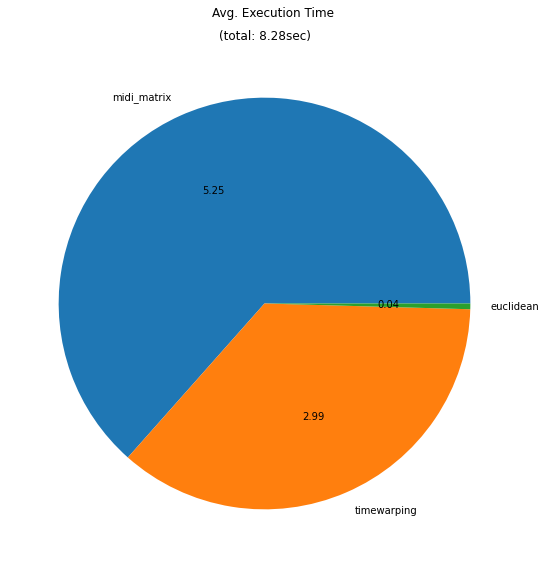

In [24]:
total = 0.0
labels = []
avg_execution_times = []
for k, v in execution_times.items():
    if k != "total":
        labels.append(k)
        avg_execution_times.append(v / count)
    else:
        total = v
plt.figure(figsize=(8, 8), facecolor="white")
plt.suptitle("Avg. Execution Time")
plt.title(f"(total: {total:.2f}sec)")
plt.pie(avg_execution_times, labels=labels, autopct=lambda x: np.round(x/100 * total, 2))
plt.tight_layout()
plt.show()


In [ ]:
pos_similarities = np.array(pos_similarities)
neg_similarities = np.array(neg_similarities)

In [ ]:
fig = plt.figure("scatter_2d", facecolor="white")
ax = fig.gca()
ax.set_title(f"expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME}")
ax.set_xlabel("Histogram distance")
ax.set_ylabel("Timewarping distance")
ax.scatter(pos_similarities[:, 0], pos_similarities[:, 1], c="k", label="Positive")
ax.scatter(neg_similarities[:, 0], neg_similarities[:, 1], c="w", edgecolors="k", label="Negative")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure("scatter_3d", facecolor="white")
ax = fig.gca(projection="3d")
ax.set_title(f"expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME}")
ax.set_xlabel("Histogram distance")
ax.set_ylabel("Timewarping distance")
ax.set_zlabel("Length ratio")
ax.scatter(pos_similarities[:,0], pos_similarities[:,1], pos_similarities[:,2], c="k", label="Positive")
ax.scatter(neg_similarities[:,0], neg_similarities[:,1], neg_similarities[:,2], c="w", edgecolors="k", label="Negative")
plt.legend()
plt.show()